<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D2_CNN1_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import re
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return 0

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/Dataset2/FGNET/images'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".JPG"):
    match = re.search(r'A(\d+)', filename)
    age_str = match.group(1)
    age = int(age_str)
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (1002, 224, 224, 3)
Labels shape: (1002, 7)


In [9]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,3-9
1,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,1-2
2,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,10-20
3,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,3-9
4,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,28-45
5,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,10-20
6,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,28-45
7,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,46-65
8,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,46-65
9,/content/drive/MyDrive/Dataset/Dataset2/FGNET/...,28-45


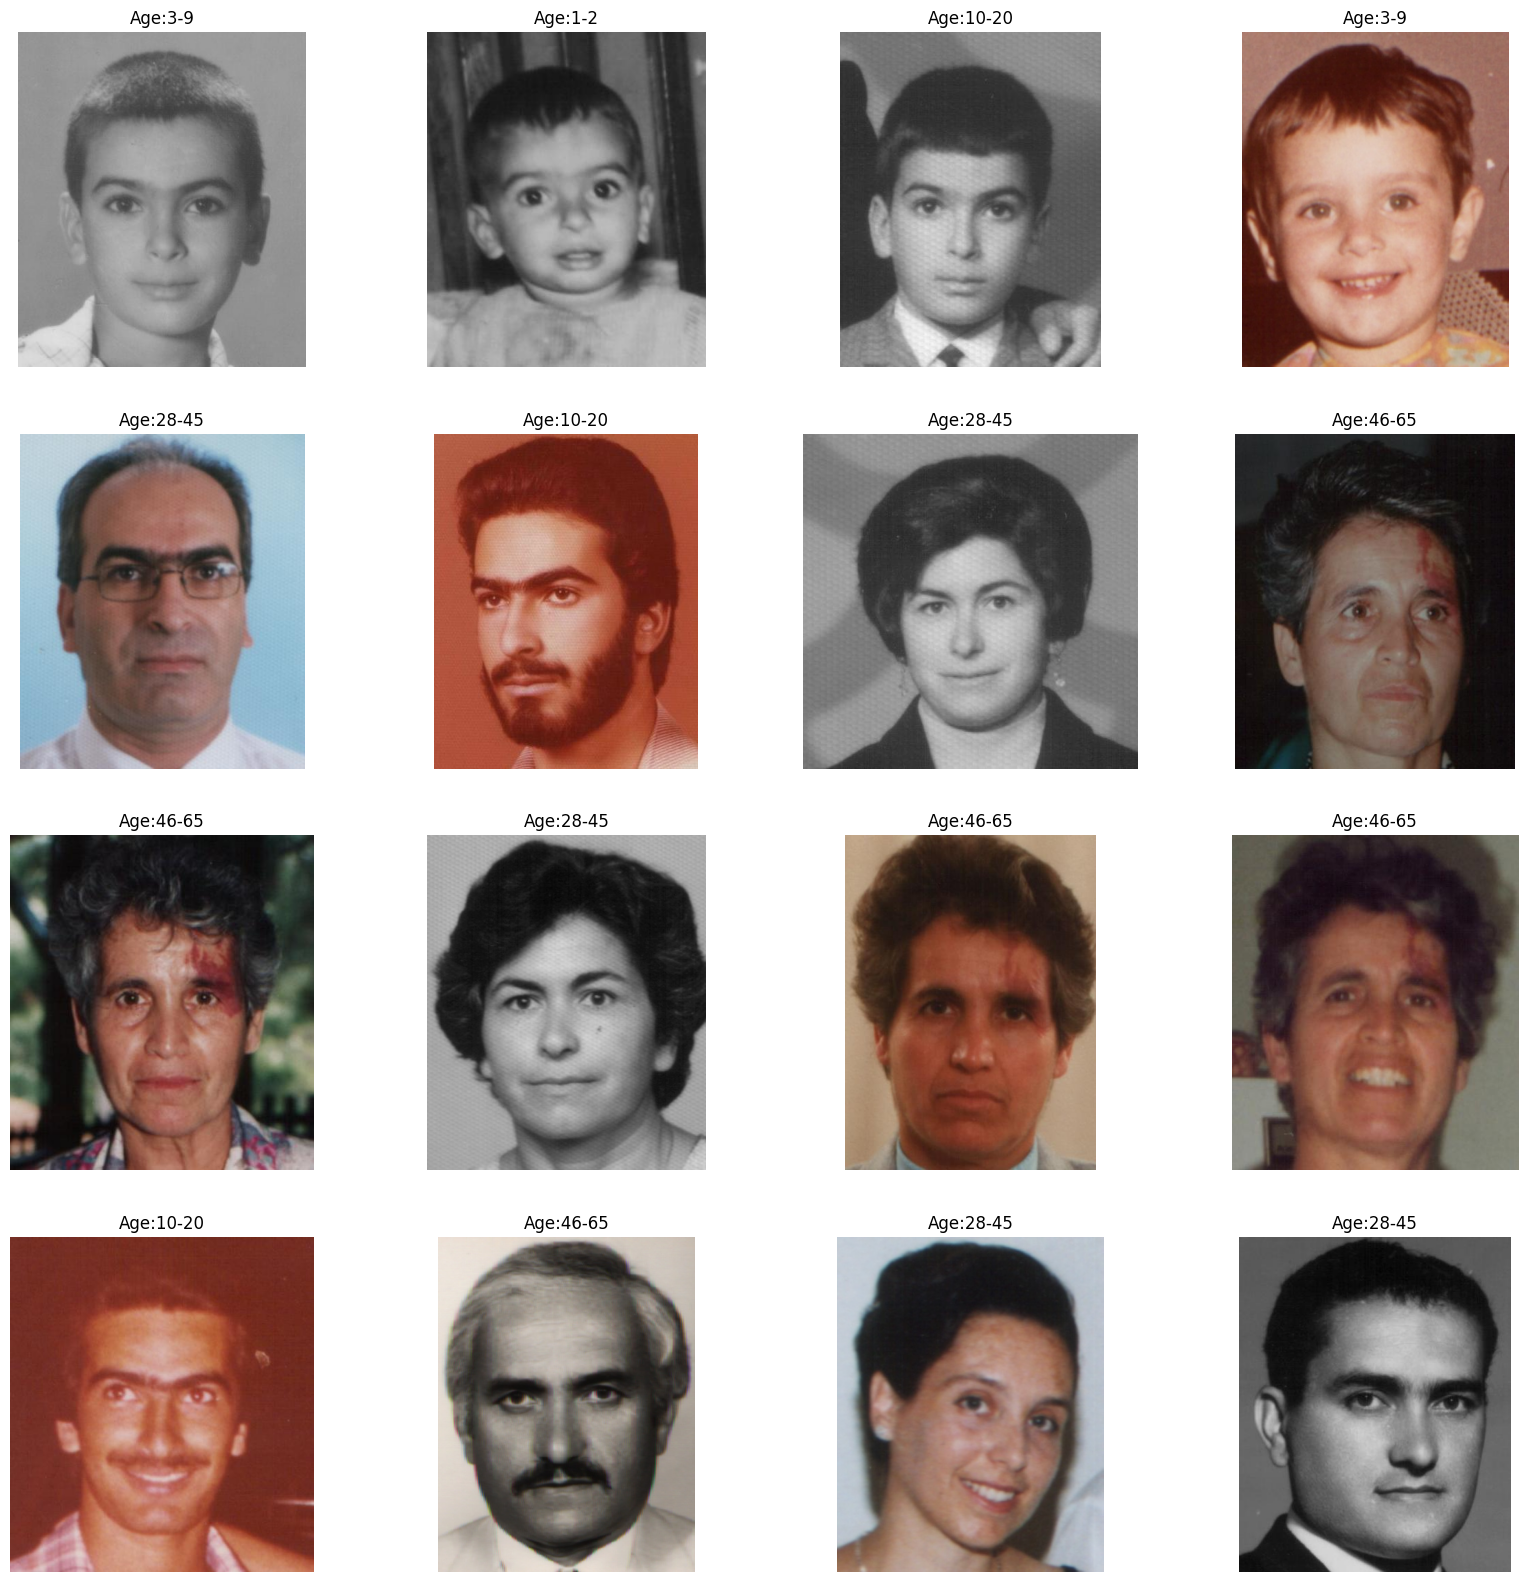

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

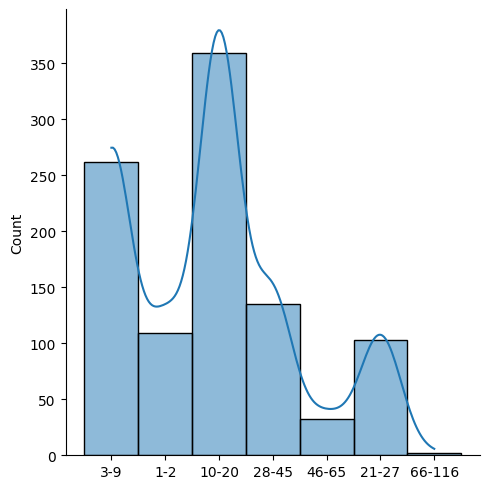

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN1_A3.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [16]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[model_checkpoint], shuffle=False)


Epoch 1/60
20/20 [==============================] - ETA: 0s - loss: 1.4977 - accuracy: 0.4281
Epoch 1: val_accuracy improved from -inf to 0.50932, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN1_A3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 58s 1s/step - loss: 1.4977 - accuracy: 0.4281 - val_loss: 1.2836 - val_accuracy: 0.5093
Epoch 2/60
20/20 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.9422
Epoch 2: val_accuracy did not improve from 0.50932
20/20 [==============================] - 3s 173ms/step - loss: 0.3221 - accuracy: 0.9422 - val_loss: 1.5190 - val_accuracy: 0.4907
Epoch 3/60
20/20 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.50932
20/20 [==============================] - 3s 173ms/step - loss: 0.0617 - accuracy: 1.0000 - val_loss: 1.6141 - val_accuracy: 0.5093
Epoch 4/60
20/20 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.50932 to 0.52174, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN1_A3.h5
20/20 [==============================] - 5s 246ms/step - loss: 0.0155 - accuracy: 1.0

In [17]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D3_CNN1_A3.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


7/7 [==============================] - 1s 152ms/step - loss: 1.5952 - accuracy: 0.6318
Test Accuracy: 63.18%


In [18]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

7/7 [==============================] - 1s 48ms/step


In [19]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.45      0.83      0.59        12
           1       0.71      0.72      0.72        54
           2       0.67      0.77      0.72        78
           3       0.50      0.07      0.13        27
           4       0.52      0.73      0.60        22
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         2

    accuracy                           0.63       201
   macro avg       0.41      0.45      0.39       201
weighted avg       0.60      0.63      0.59       201



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.63
Precision: 0.60
Recall: 0.63
F1-score: 0.59


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [22]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.83
Accuracy for age range 3-9: 0.72
Accuracy for age range 10-20: 0.77
Accuracy for age range 21-27: 0.07
Accuracy for age range 28-45: 0.73
Accuracy for age range 46-65: 0.00
Accuracy for age range 66-116: 0.00


In [23]:
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.45      0.83      0.59        12
         3-9       0.71      0.72      0.72        54
       10-20       0.67      0.77      0.72        78
       21-27       0.50      0.07      0.13        27
       28-45       0.52      0.73      0.60        22
       46-65       0.00      0.00      0.00         6
      66-116       0.00      0.00      0.00         2

    accuracy                           0.63       201
   macro avg       0.41      0.45      0.39       201
weighted avg       0.60      0.63      0.59       201


Confusion Matrix:
[[10  2  0  0  0  0  0]
 [10 39  5  0  0  0  0]
 [ 1 11 60  2  4  0  0]
 [ 0  1 20  2  4  0  0]
 [ 1  2  3  0 16  0  0]
 [ 0  0  1  0  5  0  0]
 [ 0  0  0  0  2  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
